# Intro

The goal of this post is to hand implement a single attention head from a transformer model and then use it to autoregressively produce a sequence.




# Super minimal transformer architecture

The attention head is parameterized by three weight matrices $W_K$, $W_Q$, and $W_V$. 

The input matrix $X$ has the interpretation that each of its columns represents one of the input tokens from the previous layer or the input. 

First, $X$ is seperately multiplied by each of the weight matrices to create $K$, $Q$, and $V$.

Second, the attention mechanism is implemented as the following sequence of matrix multiplications:

$$Y=Softmax(K^TQ)V$$

The resulting matrix $Y$ is of the same dimensions as the input matrix $X$ and has the same interpretation: that its columns represent the embedding of the individual input tokens. 

Finally, $Y$ can be passed to another attention layer or as we will do here it can be flattened into a vector and then projected to a vector (using a final parameter matrix $W_P$) that will be softmaxed and interpreted as the probability distribution of the next token in the input sequence.

In [ ]:
import tensorflow as tf
import numpy as np

def SelfAttention(X, Wk, Wq, Wv, Wp):
  """
  Returns Y, the same dimensions as the input X
  """
  #1.
  K = tf.matmul(Wk,X)
  Q = tf.matmul(Wq,X)
  V = tf.matmul(Wv,X)

  #2.
  Y = tf.matmul(tf.nn.softmax(tf.matmul(Q,tf.transpose(K))),V)

  #3.
  Y = tf.reshape(Y,[-1,1])
  Y = tf.matmul(Wp,Y)
  Y = tf.nn.relu(Y)
  Y = tf.nn.softmax(Y,axis=0)

  return Y

###Test

In [ ]:
#Test
INPUT_SEQUENCE_LENGTH = 5
EMBEDDING_DIMENSION   = 10
NUM_TOKENS            = 3


X = tf.constant(np.zeros(shape=(EMBEDDING_DIMENSION,INPUT_SEQUENCE_LENGTH)))
Wk = tf.constant(np.zeros(shape=(EMBEDDING_DIMENSION,EMBEDDING_DIMENSION)))
Wq = tf.constant(np.zeros(shape=(EMBEDDING_DIMENSION,EMBEDDING_DIMENSION)))
Wv = tf.constant(np.zeros(shape=(EMBEDDING_DIMENSION,EMBEDDING_DIMENSION)))
Wp = tf.constant(np.zeros(shape=(NUM_TOKENS,INPUT_SEQUENCE_LENGTH*EMBEDDING_DIMENSION)))


SelfAttention(X,Wk,Wq,Wv,Wp)

tf.Tensor([10  5], shape=(2,), dtype=int32)


<tf.Tensor: shape=(3, 1), dtype=float64, numpy=
array([[1.],
       [1.],
       [1.]])>

# Sample from model


In [ ]:
def Sample():
  SAMPLE_STEPS = 200


  #Initialize model
  INPUT_SEQUENCE_LENGTH = 5
  EMBEDDING_DIMENSION   = 10
  NUM_TOKENS            = 3
  X = tf.transpose(tf.one_hot([4 for _ in range(INPUT_SEQUENCE_LENGTH)],EMBEDDING_DIMENSION,dtype=tf.double))
  Wk = tf.constant(np.random.uniform(low=-1., high=1., size=(EMBEDDING_DIMENSION,EMBEDDING_DIMENSION)))
  Wq = tf.constant(np.random.uniform(low=-1., high=1., size=(EMBEDDING_DIMENSION,EMBEDDING_DIMENSION)))
  Wv = tf.constant(np.random.uniform(low=-1., high=1., size=(EMBEDDING_DIMENSION,EMBEDDING_DIMENSION)))
  Wp = tf.constant(np.random.uniform(low=-1., high=1., size=((NUM_TOKENS,INPUT_SEQUENCE_LENGTH*EMBEDDING_DIMENSION))))



  #Autoregressively sample

  sample = []

  for step in range(SAMPLE_STEPS):
    Y = SelfAttention(X,Wk,Wq,Wv,Wp)
    next_token = tf.argmax(Y).numpy()
    
    sample.append(next_token[0])

    X = tf.concat([ X[:,1:],tf.transpose(tf.one_hot(next_token, EMBEDDING_DIMENSION,dtype=tf.double)) ],axis=1)
  return sample

print(sample)

[0, 0, 1, 1, 1, 0, 0, 1, 2, 1, 0, 0, 0, 1, 1, 0, 1, 2, 1, 1, 0, 0, 0, 1, 1, 0, 1, 2, 1, 1, 0, 0, 0, 1, 1, 0, 1, 2, 1, 1, 0, 0, 0, 1, 1, 0, 1, 2, 1, 1, 0, 0, 0, 1, 1, 0, 1, 2, 1, 1, 0, 0, 0, 1, 1, 0, 1, 2, 1, 1, 0, 0, 0, 1, 1, 0, 1, 2, 1, 1, 0, 0, 0, 1, 1, 0, 1, 2, 1, 1, 0, 0, 0, 1, 1, 0, 1, 2, 1, 1]


#Visualize sampled sequence (for no reason)

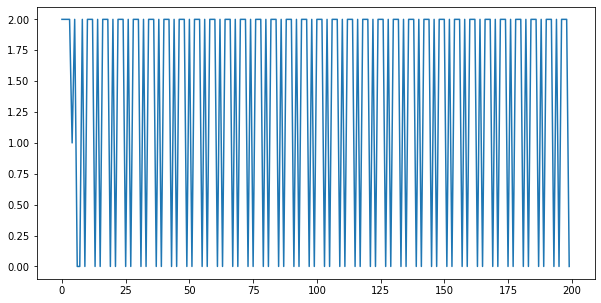

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))

sample=Sample()
plt.plot(sample)